In [1]:
%matplotlib notebook

In [2]:
import calour as ca
import numpy as np
import pandas as pd
from calour.training import plot_roc
import matplotlib.pyplot as plt
ca.set_log_level(40)

In [3]:
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
import skbio.stats.distance as ssd
from emperor import Emperor

First, we will load the table with relative abundance of 16S tag sequences (normalized to 100) in Ldlr and ApoE KO along with metadata about all samples in the study using calour (http://biocore.github.io/calour/). 
We are interested in looking at fecal metabolome in this study, so we will filter out all other sample types. Lastly, we just include samples from mice that were fed high-fat diet (HFD) as HFD promoted atherosclerosis in our animal models; this is the phenotype of interest. 

**Description of metadata columns that we use for this analysis**
1. body_habitat : type of sample (fecal, plasma, oral etc.)
2. diet : 'HFD' (High-fat diet) or 'Regular chow' given to mice
3. exposure_type : 'Air' or 'IHH' (intermittent hypoxia and hypercapnia) exposure
4. mouse_number : denotes unique mouse ID for each mouse in the study
5. genotype : 'ApoE KO' (ApoE knockout animals) or 'Ldlr knockout' 
6. age : age of mice in weeks (the study starts at 10 weeks of age)

# 16S composition

### Shared and unique features between the ApoE KO and Ldlr KO

In [13]:
# loading unnormalized counts for each model
ldlr = ca.read_amplicon('../data/microbiome/ldlr-deblur-refererence-hit.biom', 
                        '../data/combined_sample_metadata_HFD.txt', normalize=None, min_reads=0)

apoe = ca.read_amplicon('../data/microbiome/apoe-deblur-reference-hit.biom',
                        '../data/combined_sample_metadata_HFD.txt', normalize=None, min_reads=0)

# only retain fecal samples from mouse fed HFD
apoe = apoe.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')
ldlr = ldlr.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

**QC sequences:** We apply abundance-based filtering within each model, keeping only the features above 10E-6 relative abundance in at least 1% of the samples. 

In [14]:
# normalizing each sample to 100 
ldlr_norm = ldlr.normalize(total=100, axis=0)
apoe_norm = apoe.normalize(total=100, axis=0)

# filtering by prevalence
ldlrf = ldlr_norm.filter_prevalence(cutoff=0.000001, fraction=0.01)
apoef = apoe_norm.filter_prevalence(cutoff=0.000001, fraction=0.01)

In [15]:
# features in ldlr
f_ldlr = ldlrf.feature_metadata.index
print("Sequences in Ldlr KO: ", len(f_ldlr))

# feature in apoe
f_apoe = apoef.feature_metadata.index
print("Sequences in ApoE KO: ", len(f_apoe))

#shared features
print("Shared sequences in Ldlr and ApoE KO: ", len(f_apoe.intersection(f_ldlr)))

#unique features
print("Unique sequences in ApoE KO: ", len(set(f_apoe) - set(f_apoe.intersection(f_ldlr))))
print("Unique sequences in Ldlr KO: ", len(set(f_ldlr) - set(f_apoe.intersection(f_ldlr))))

Sequences in Ldlr KO:  635
Sequences in ApoE KO:  582
Shared sequences in Ldlr and ApoE KO:  248
Unique sequences in ApoE KO:  334
Unique sequences in Ldlr KO:  387


### Combined analysis of ApoE and LDLR KO animal models

In [16]:
# combine the unrarefied & unnormalized tables
exp = apoe.join_experiments(ldlr)

In [17]:
# number of samples in each animal model
exp.sample_metadata.genotype.value_counts()

ApoE KO          460
LDLR knockout    182
Name: genotype, dtype: int64

In [19]:
# save combined feature table
exp.save_biom('../data/microbiome/combined_apoe_ldlr_norare.biom', fmt='hdf5', add_metadata='taxonomy')

This combined feature table was rarefied to 2000 counts per sample using QIIME2 (https://docs.qiime2.org/2018.11/plugins/available/feature-table/rarefy/). Below, we load this rarefied table.

In [22]:
# load table rarefied to 2k
exp = ca.read_amplicon('../data/microbiome/combined_apoe_ldlr_norare_2k/feature-table.biom', 
                        '../data/combined_sample_metadata_HFD.txt', normalize=100, min_reads=0,
                      feature_metadata_file='../data/microbiome/taxonomy/taxonomy_reform.txt')
exp.shape

(642, 2794)

**QC Sequences:** Below, we perform abundance-based filtering of features to retain only high-quality reliable features that are present above a certain threshold (cutoff) in at least a certain fraction (fraction) of samples within each animal model. 
Here, we use an abundance threshold of 10E-6 and we want the feature to be present in atleast 1% of the samples in each animal model.

In [23]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'genotype'
expf = exp.filter_prevalence(field='genotype', cutoff=0.000001, fraction=0.01)
expf.shape

(642, 443)

<IPython.core.display.Javascript object>


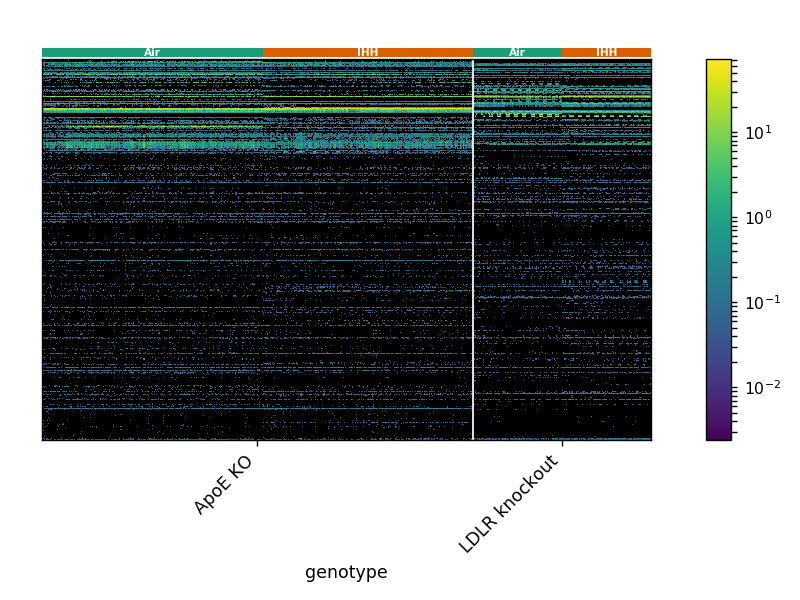

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [24]:
# remove baseline samples
expf = expf.filter_samples(field='age', values=['10', '10.5'], negate=True)

# heatmap to compare all the samples and timepoints across genotypes
expfc = expf.cluster_features()
expfc = expfc.sort_samples(field='age').sort_samples(field='exposure_type').sort_samples(field='genotype')
f = expfc.plot(sample_field='genotype', gui='jupyter', barx_fields=['exposure_type'],
              barx_label_kwargs={'size': 6})

In [25]:
f.save_figure('../figures/animal_comparision_16S_norare_combined_2k_filter.pdf')

<IPython.core.display.Javascript object>


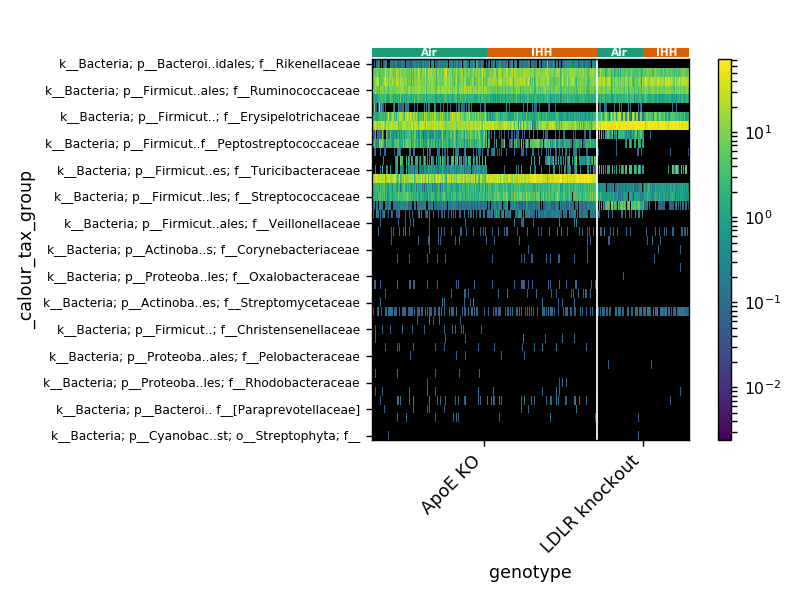

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [27]:
## collapse taxonomy at family level
fam = expfc.collapse_taxonomy(level='family', inplace=False)
f = fam.plot(sample_field='genotype', gui='jupyter', barx_fields=['exposure_type'],
              barx_label_kwargs={'size': 6}, feature_field='_calour_tax_group', 
              yticklabel_kwargs={'size':7,'rotation': 0}, yticklabel_len=50,
              yticks_max=20)

In [53]:
f.save_figure('../figures/animal_comparision_16S_norare_combined_2k_filter_family.pdf')

### Distance boxplots (unweighted Unifrac distances)

In [38]:
import seaborn as sns
%matplotlib inline

We used UniFrac distances between every pair of sample to do the analyses below. The data used below (```raw_data```) was generated using ```qiime diversity beta-group-significance``` module (https://docs.qiime2.org/2018.11/plugins/available/diversity/beta-group-significance/)

In [39]:
raw_data = pd.read_table('../data/microbiome/unweighted_boxplot_raw_data.tsv', sep='\t', index_col=0)

In [40]:
raw_data.head()

,SubjectID1,SubjectID2,Group1,Group2,Distance
0,11548.A21.112.11,11548.A23.119.20,Air_ApoE KO,Air_ApoE KO,0.298967
1,11548.A21.112.8,11548.A23.119.20,Air_ApoE KO,Air_ApoE KO,0.249852
2,11548.A21.112.8,11548.A21.112.11,Air_ApoE KO,Air_ApoE KO,0.207509
3,11548.A22.113.17,11548.A23.119.20,Air_ApoE KO,Air_ApoE KO,0.311470
4,11548.A22.113.17,11548.A21.112.11,Air_ApoE KO,Air_ApoE KO,0.352150


In [41]:
reference = 'Air_ApoE KO'

In [42]:
to_plot = raw_data.loc[raw_data['Group1'] == reference]
to_plot.shape

(100436, 5)

In [43]:
to_plot.Group2.value_counts()

IHH_ApoE KO          42411
Air_ApoE KO          22155
IHH_LDLR knockout    17935
Air_LDLR knockout    17935
Name: Group2, dtype: int64

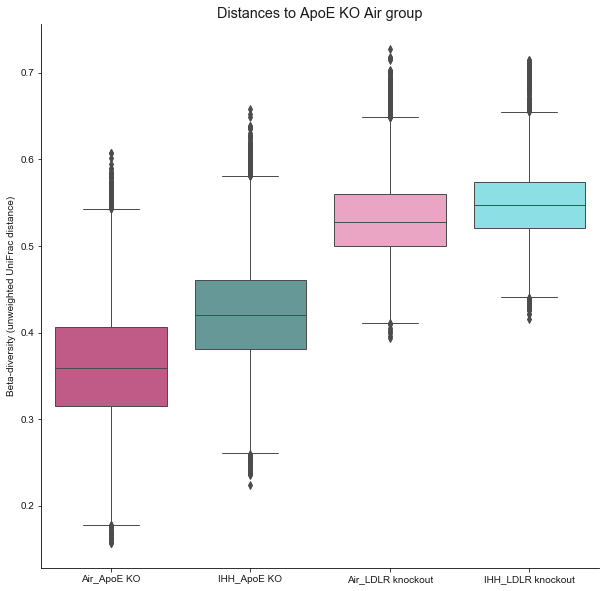

In [44]:
fig, axs = plt.subplots(figsize=(10, 10))
# sns.set_context("paper")
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# matching colors to PCoA
color_palette = {'Air_ApoE KO': '#d14a86', 'IHH_ApoE KO': '#5da09e', 'Air_LDLR knockout': '#f49ac2', 
                 'IHH_LDLR knockout': '#7cecf4'} 

sns.boxplot(x='Group2', y='Distance', data=to_plot, 
            order=['Air_ApoE KO', 'IHH_ApoE KO', 'Air_LDLR knockout', 'IHH_LDLR knockout'],
            linewidth=1, ax=axs, palette=color_palette)

axs.set(title = 'Distances to ApoE KO Air group', ylabel='Beta-diversity (unweighted UniFrac distance)', xlabel="")
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

In [45]:
fig.savefig("../figures/unweighted_boxplot_exposure_genotype.pdf")

### Principal Coordinate Analysis using UniFrac distances (unweighted)

In [28]:
from skbio.stats.ordination import pcoa
import skbio.stats.distance as ssd
from emperor import Emperor

In [29]:
metadata = pd.read_table('../data/combined_sample_metadata_HFD.txt', sep='\t', index_col='#SampleID')

In [30]:
metadata['exposure_genotype'] = metadata['exposure_type'] + '_' + metadata['genotype']

In [31]:
metadata.reset_index().to_csv('../data/combined_sample_metadata_HFD.txt', 
                              sep='\t', index=False)

#### all samples

In [33]:
uwdm = ssd.DistanceMatrix.read('../data/microbiome/unweighted_dm/distance-matrix.tsv')
uwpc = pcoa(uwdm)
Emperor(uwpc, metadata, ignore_missing_samples=True)

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.13123345454651592 and the largest is 19.291086062056955.
  RuntimeWarning


#### without baseline samples 

In [34]:
# remove baseline samples
not_baseline =  [sample for sample in metadata.index if metadata.loc[sample, 'age'] not in [10, 10.5] ]
uwdm_no_base = uwdm.filter(ids=not_baseline, strict=False)

uwpc = pcoa(uwdm_no_base)
Emperor(uwpc, metadata, ignore_missing_samples=True)

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.12842624323611398 and the largest is 19.025567369913418.
  RuntimeWarning


In [40]:
#save for QIIME2
# uwdm_no_base.to_data_frame().to_csv('../data/microbiome/unweighted_dm_no_base.txt', sep='\t')

#### ApoE model

In [36]:
# keep only apoe samples
apoe_samples =  [sample for sample in metadata.index if metadata.loc[sample, 'genotype'] == 'ApoE KO' ]
uwdm_apoe = uwdm_no_base.filter(ids=apoe_samples, strict=False)

uwpc = pcoa(uwdm_apoe)
Emperor(uwpc, metadata, ignore_missing_samples=True)

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.10617455344198569 and the largest is 4.787373639218228.
  RuntimeWarning


In [42]:
#save for QIIME2
# uwdm_apoe.to_data_frame().to_csv('../data/microbiome/unweighted_dm_apoe.txt', sep='\t')

#### LDLR model

In [37]:
# keep only ldlr samples
ldlr_samples =  [sample for sample in metadata.index if metadata.loc[sample, 'genotype'] == 'LDLR knockout' ]
uwdm_ldlr = uwdm_no_base.filter(ids=ldlr_samples, strict=False)

uwpc = pcoa(uwdm_ldlr)
Emperor(uwpc, metadata, ignore_missing_samples=True)

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04586409307726414 and the largest is 1.8393429531380718.
  RuntimeWarning


In [45]:
#save for QIIME2
# uwdm_ldlr.to_data_frame().to_csv('../data/r1/microbiome/unweighted_dm_ldlr.txt', sep='\t')